In [43]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from astropy import wcs
from astropy.io import fits

In [44]:
def load_cat(filename):

    return pd.read_csv(filename, sep=r'\s+', skiprows=5, header=None, names=["ra", "dec",
            "flux", "flux_err"])

In [45]:
hdulB = fits.open("data/coadd.fits")
hduB = hdulB[0]
imageB = hduB.data.T

In [46]:
hdulV = fits.open("data/coadd_V.fits")
hduV = hdulV[0]
imageV = hduV.data.T

In [47]:
flatB = fits.open("data/median_flat_b.fits")[0].data
flatV = fits.open("data/median_flat_v.fits")[0].data

flatB = np.median(flatB)
flatV = np.median(flatV)

imageB *= flatB
imageV *= flatV

In [48]:
# Bounds on viewing windows
ylo_B, yhi_B = 675, 925
xlo_B, xhi_B = 325, 825
ylo_V, yhi_V = 575, 825
xlo_V, xhi_V = 325, 825

In [49]:
def plot_galaxy_B():
    
    plt.imshow(imageB[ylo_B:yhi_B, xlo_B:xhi_B], cmap="magma", vmin=0.045*flatB, vmax=0.05*flatB)
    plt.colorbar()
    
def plot_galaxy_V():
    
    plt.imshow(imageV[ylo_V:yhi_V, xlo_V:xhi_V], cmap="magma", vmin=0.094*flatV,vmax=0.105*flatV)
    plt.colorbar()

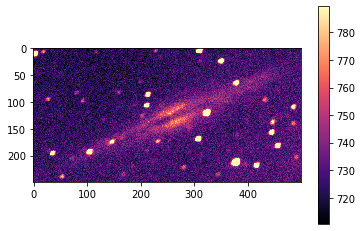

In [50]:
plot_galaxy_B()

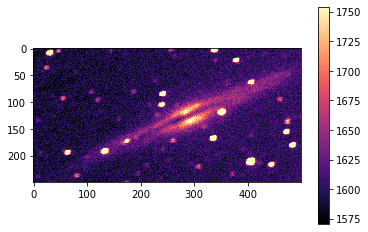

In [51]:
plot_galaxy_V()

In [52]:
warnings.filterwarnings('ignore', category=wcs.FITSFixedWarning)

In [53]:
cat_B = load_cat("data/B_gal.cat")
cat_B.sort_values(by="flux", ascending=False, inplace=True)
w_B = wcs.WCS(hduB.header)
starwcs_B = np.stack((cat_B["ra"], cat_B["dec"])).T

In [54]:
cat_V = load_cat("data/V_gal.cat")
cat_V.sort_values(by="flux", ascending=False, inplace=True)
w_V = wcs.WCS(hduV.header)
starwcs_V = np.stack((cat_B["ra"], cat_B["dec"])).T

In [55]:
starpix_B = w_B.wcs_world2pix(starwcs_B, 0)
starpix_V = w_V.wcs_world2pix(starwcs_V, 0)

In [56]:
indx_B = np.indices(imageB.shape)
pix_B = np.stack((indx_B[0].flatten(), indx_B[1].flatten())).T

indx_V = np.indices(imageV.shape)
pix_V = np.stack((indx_V[0].flatten(), indx_V[1].flatten())).T

In [57]:
for pair in starpix_B:
    
    dist = np.sqrt(((pix_B - pair)**2).sum(axis=1))
    inradius = pix_B[dist < 9.6].T
    imageB[inradius[0], inradius[1]] = 0.0

In [58]:
for pair in starpix_V:
    
    dist = np.sqrt(((pix_V - pair)**2).sum(axis=1))
    inradius = pix_V[dist < 9.6].T
    imageV[inradius[0], inradius[1]] = 0.0

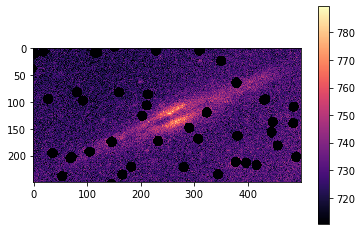

In [59]:
plot_galaxy_B()

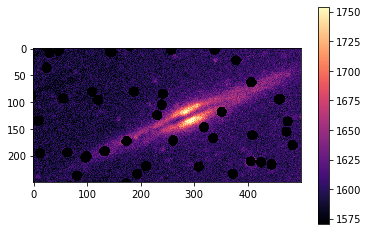

In [60]:
plot_galaxy_V()

In [61]:
def parx(t, x0, y0, a, b, theta):
    
    return a*np.cos(t)*np.cos(theta) - b*np.sin(t)*np.sin(theta) + x0

def pary(t, x0, y0, a, b, theta):
    
    return a*np.cos(t)*np.sin(theta) + b*np.sin(t)*np.cos(theta) + y0

def plot_ellipse(x0, y0, a, b, theta):
    
    t = np.linspace(0, 2*np.pi)
    x = parx(t, x0, y0, a, b, theta)
    y = pary(t, x0, y0, a, b, theta)
    plt.plot(x, y, color="deepskyblue")

In [62]:
a, b, theta = 220, 22, -0.13 * np.pi
x0_B, y0_B = 263, 125
x0_V, y0_V = 279, 132

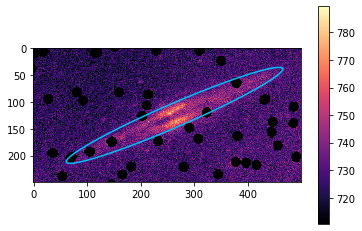

In [63]:
plot_galaxy_B()
plot_ellipse(x0_B, y0_B, a, b, theta)

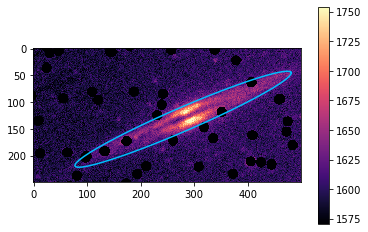

In [64]:
plot_galaxy_V()
plot_ellipse(x0_V, y0_V, a, b, theta)

In [65]:
def inside_ellipse(x, y, *par):
    
    x0, y0, a, b, theta = par
    
    t = np.linspace(0, 2*np.pi, num=10000)
    x_t = parx(t, x0, y0, a, b, theta)
    y_t = pary(t, x0, y0, a, b, theta)
    
    dx = np.abs(x_t - x)
    dy = np.abs(y_t - y)
    
    i1 = np.argmin(dx)
    j1 = np.argmin(dy)
    
    dx[i1] = float("inf")
    dy[j1] = float("inf")
    
    i2 = np.argmin(dx)
    j2 = np.argmin(dy)
    
    x1, x2 = sorted([x_t[j1], x_t[j2]])
    y1, y2 = sorted([y_t[i1], y_t[i2]])
    
    inside  = x1 <= x <= x2
    inside &= y1 <= y <= y2
    return inside

In [66]:
x_B = pix_B.T[1].reshape(imageB.shape)[ylo_B:yhi_B, xlo_B:xhi_B] - xlo_B
y_B = pix_B.T[0].reshape(imageB.shape)[ylo_B:yhi_B, xlo_B:xhi_B] - ylo_B
y_B = y_B[::-1]

x_V = pix_V.T[1].reshape(imageV.shape)[ylo_V:yhi_V, xlo_V:xhi_V] - xlo_V
y_V = pix_V.T[0].reshape(imageV.shape)[ylo_V:yhi_V, xlo_V:xhi_V] - ylo_V
y_V = y_V[::-1]

In [67]:
def indices_in_ellipse(x, y, *par):
    
    imax, jmax = x.shape

    for i in range(imax):
        for j in range(jmax):
            if inside_ellipse(x[i][j], y[i][j], *par):
                yield i, j

In [68]:
indx_gen = indices_in_ellipse(x_B, y_B, x0_B, y0_B, a, b, theta)
ind_dim1_B, ind_dim2_B = np.array(list(indx_gen)).T
ind_dim1_B += ylo_B
ind_dim2_B += xlo_B

In [69]:
bgB = np.copy(imageB)

bgB[ind_dim1_B, ind_dim2_B] = np.nan

for pair in starpix_B:
    
    dist = np.sqrt(((pix_B - pair)**2).sum(axis=1))
    inradius = pix_B[dist < 9.6].T
    bgB[inradius[0], inradius[1]] = np.nan
    
bgB = bgB[~np.isnan(bgB)]

err_bgB = bgB.std() / np.sqrt(bgB.size)
bgB = bgB.mean()
bgB

574.5395

In [70]:
flux_B = imageB[ind_dim1_B, ind_dim2_B].sum()
err_flux_B = np.sqrt(flux_B / 25 + err_bgB**2)

imageB -= bgB

flux_B = imageB[ind_dim1_B, ind_dim2_B].sum()
print(f"B-band Flux: {flux_B:.0f} +- {err_flux_B:.0f}")

B-band Flux: 1236801 +- 632


In [71]:
indx_gen = indices_in_ellipse(x_V, y_V, x0_V, y0_V, a, b, theta)
ind_dim1_V, ind_dim2_V = np.array(list(indx_gen)).T
ind_dim1_V += ylo_V
ind_dim2_V += xlo_V

In [72]:
bgV = np.copy(imageV)
bgV[ind_dim1_V, ind_dim2_V] = np.nan

for pair in starpix_V:
    
    dist = np.sqrt(((pix_V - pair)**2).sum(axis=1))
    inradius = pix_V[dist < 9.6].T
    bgV[inradius[0], inradius[1]] = np.nan

bgV = bgV[~np.isnan(bgV)]

err_bgV = bgV.std() / np.sqrt(bgV.size)
bgV = bgV.mean()
bgV

1264.6603

In [73]:
flux_V = imageV[ind_dim1_V, ind_dim2_V].sum()
err_flux_V = np.sqrt(flux_V / 25 + err_bgV**2)

imageV -= bgV

flux_V = imageV[ind_dim1_V, ind_dim2_V].sum()
print(f"V-band Flux: {flux_V:.0f} +- {err_flux_V:.0f}")

V-band Flux: 2808634 +- 939


In [74]:
b_minus_v = -2.5*np.log10(flux_B/flux_V)
err_rat = np.sqrt((err_flux_B/flux_V)**2 + (err_flux_V*flux_B/flux_V**2)**2)
b_minus_v_err = 2.5*flux_V/flux_B/np.log(10) * err_rat
print(f"{b_minus_v:.4f} +- {b_minus_v_err:.4f}")

0.8905 +- 0.0007


In [75]:
d_gal = 27.3 # Mly

In [76]:
def distances(starcoords, catframe):
    
    alpha, delta = starcoords
    dra = (alpha - catframe['ra']) * np.cos(delta)
    ddec = delta - catframe['dec']
    return np.sqrt(dra**2 + ddec**2)
    
def fuzzy_match(starcoords, catframe):
    
    gamma = distances(starcoords, catframe)
    indx = gamma.idxmin()
    
    return catframe.loc[indx]

In [77]:
starcoords = 35.590435, 42.396332
ref_row = fuzzy_match(starcoords, cat_V)
flux_ref = ref_row['flux'] * flatV
err_flux_ref = ref_row['flux_err'] * np.sqrt(flatV)
mag_ref = 10.81
err_mag_ref = 0.06

In [78]:
mag_gal = mag_ref - 2.5*np.log10(flux_V/flux_ref)
err_rat = np.sqrt((err_flux_V/flux_ref)**2 + (err_flux_ref*flux_V/flux_ref**2)**2)
err_modulus = 2.5*flux_ref/flux_V/np.log(10) * err_rat
err_gal = np.sqrt(err_mag_ref**2 + err_modulus**2)
print(f"{mag_gal:.1f} +- {err_gal:.1f}")

8.9 +- 0.1


In [79]:
degrees_per_pixel = 1.4 / 3600
#given by the spec sheet
degrees_from_center = degrees_per_pixel * a
distance_to_galaxy = 8.4 * 1000 #in kpc
distance_to_galaxy_error = 0.5 * 1000
distance_from_center = distance_to_galaxy * degrees_from_center * (np.pi/180)
distance_from_center_error = distance_to_galaxy_error * degrees_from_center *(np.pi/180)
distance_from_center, distance_from_center_error

(12.543099557665915, 0.7466130689086854)

In [80]:
v = 226.6 * 1000 #m/s
#from https://arxiv.org/pdf/1105.3867.pdf
velocity_error = 2.7 * 1000 #this accounts for error in distance because the error is larger than the 
#difference between the velocities at different radii
mass_of_galaxy = v**2 * distance_from_center * 3.086e19 / 6.67e-11 / 1.989e30
error_in_mass = np.sqrt((2*v*distance_from_center*3.086e19*velocity_error/6.67e-11/1.989e30)**2 
                        + (v**2*distance_from_center_error*3.086e19 / 6.67e-11/1.989e30)**2)
mass_of_galaxy/1e9, error_in_mass/1e9

(149.81661667524227, 9.605778892861748)

In [81]:
m_galaxy = mag_gal
M_galaxy = m_galaxy - 5*np.log10(distance_to_galaxy/1000) - 25
M_err_galaxy = np.sqrt(err_gal**2 + (5/(distance_to_galaxy/1000)/np.log(10)*distance_to_galaxy_error)**2)
m_star = mag_ref

dist_to_star = 1/(19.37/1000) #from simbad
error_in_star_dist = 1/(19.37/1000)**2 * 0.19/1000
M_star = m_star - 5 * np.log10(dist_to_star/10)
err_M_star = (err_mag_ref**2 + (50/dist_to_star/np.log(10))**2)

star_luminosity = 10**((4.83-M_star)/2.5) #solar_luminosities
err_star_luminosity = -78.8*np.exp(-.92*star_luminosity)*err_M_star
luminosity_of_galaxy = star_luminosity * 10**((M_star - M_galaxy)/2.5)
err_luminosity_of_galaxy = np.sqrt((err_star_luminosity*10**((M_star - M_galaxy)/2.5))**2 + 
                                  (err_M_star*star_luminosity * .92 * np.exp(.92*((M_star - M_galaxy))))**2 
                                   + (-M_err_galaxy*star_luminosity * .92 * np.exp(-.92*((M_star - M_galaxy))))**2)

alpha = -0.9
beta  = 1.627
mass_from_luminosity = 10**(alpha + beta*(b_minus_v)) * luminosity_of_galaxy
mass_luminosity_error = np.sqrt((10**(alpha + beta*(b_minus_v))*err_luminosity_of_galaxy)**2 +
                               (.472*np.exp(3.75*b_minus_v)*b_minus_v_err)**2)
mass_from_luminosity/1e9, mass_luminosity_error/1e9

(58.63760424876569, 6987.076752379728)

In [82]:
mass_of_galaxy / mass_from_luminosity

2.5549580102157035

In [83]:
dimmest_object_magnitude = mag_ref - 2.5*np.log10(0.0182636/(flux_ref/20))

In [84]:
dimmest_object_magnitude

26.117716383917536